In [9]:
# Data manipulation
from sklearn.model_selection import train_test_split
import pandas as pd

# Support Vector Machine Classifier
from sklearn.svm import SVC

# Model Metrics
from sklearn.metrics import accuracy_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Dimensionality Reduction
from sklearn.manifold import TSNE

In [2]:
# Import dataset from datasets directory
ansur = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/ansur.csv')
ansur.head()

,Gender,weight_kg,stature_m,body_height
0,Male,81.5,1.776,69.92
1,Male,72.6,1.702,67.01
2,Male,92.9,1.735,68.31
3,Male,79.4,1.655,65.16
4,Male,94.6,1.914,75.35


In [3]:
# Spot perfect correlation in data
ansur.corr()

,weight_kg,stature_m,body_height
weight_kg,1.000000,0.610908,0.610888
stature_m,0.610908,1.000000,1.000000
body_height,0.610888,1.000000,1.000000


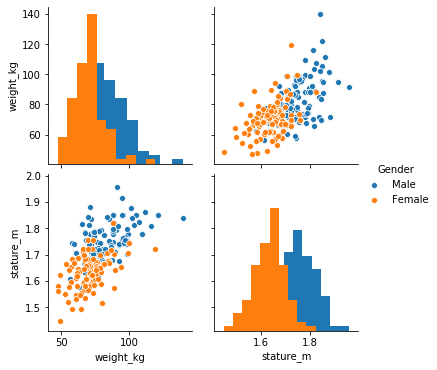

In [4]:
# Remove perfectly correlated columns as they provide redundant information
ansur = ansur.drop('body_height', axis=1)

# Check visualization
sns.pairplot(ansur, hue='Gender', diag_kind='hist')
plt.show()

In [5]:
# High dimensional data import
body_dims = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/body_measurements.csv')
print(f'Number of dimensions (cols): {len(body_dims.columns)}')

Number of dimensions (cols): 95


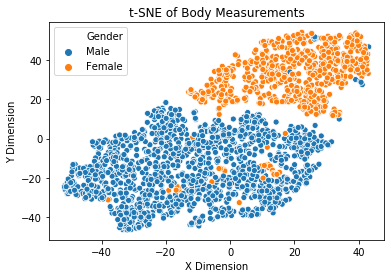

In [7]:
# Instanciate TSNE Model
tsne_model = TSNE(learning_rate=50)

# Fit and transform numeric data from 4th column
tsne_features = tsne_model.fit_transform(body_dims.iloc[:, 4:])

# Add components to df
body_dims['x'] = tsne_features[:, 0]
body_dims['y'] = tsne_features[:, 1]

# Plot transformed data
sns.scatterplot(x='x', y='y', hue='Gender', data=body_dims)
plt.xlabel('X Dimension')
plt.ylabel('Y Dimension')
plt.title('t-SNE of Body Measurements')
plt.show()

In [24]:
# Predict 'Gender' based on all body measurements
y = body_dims['Gender']
X = body_dims.drop(['ID', 'Branch', 'Component', 'Gender', 'x', 'y'], axis=1)

# Split train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

# Instanciate model and fit model
svm = SVC()
svm.fit(X_train, y_train)

# Measure accuracy
acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_test = accuracy_score(y_test, svm.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')


acc_train = 0.9714285714285714
acc_test = 0.9666666666666667
Score (train - test) / test = 0.004926108374384219


In [25]:
# Predict Gender based on 'neckcircumferencebase' feature 
y = body_dims['Gender']
X = body_dims[['neckcircumferencebase']]

# Split train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

# Instanciate model and fit model
svm = SVC()
svm.fit(X_train, y_train)

# Measure accuracy
acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_test = accuracy_score(y_test, svm.predict(X_test))

# Measure overfitting abs(train - test / test)
print(f'{acc_train = }')
print(f'{acc_test = }')

acc_train = 0.9342857142857143
acc_test = 0.9316666666666666
Score (train - test) / test = 0.002811142346026081
